In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
from orphics import maps,cosmology,io,stats,catalogs
from enlib import enmap
import numpy as np



In [2]:
lc = cosmology.LimberCosmology(lmax=3000,pickling=True)

Generating theory Cls...
Initializing CMB window..
initializing power...


In [3]:
lc.addDeltaNz("g",0.5)


('Initializing galaxy window for ', 'g', ' ...')


In [4]:
ellrange = np.arange(0,3000,1)
lc.generateCls(ellrange)
clkk = lc.getCl("cmb","cmb")
clkg = lc.getCl("cmb","g")
clgg = lc.getCl("g","g")


In [10]:
ps = np.zeros((3,3,ellrange.size))
ps[0,0] = clkk
ps[1,1] = clgg
ps[2,2] = clgg*0.
ps[0,1] = clkg
ps[1,0] = clkg

In [11]:
shape, wcs = maps.rect_geometry(width_deg=25.,px_res_arcmin=1.)
shape = (3,)+shape
mg = maps.MapGen(shape,wcs,ps)

In [12]:
imaps = mg.get_map(scalar=False,iau=False)

In [13]:
print(imaps.shape)

(3, 1500, 1500)


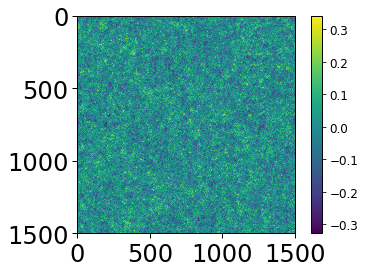

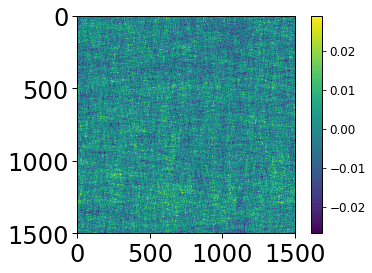

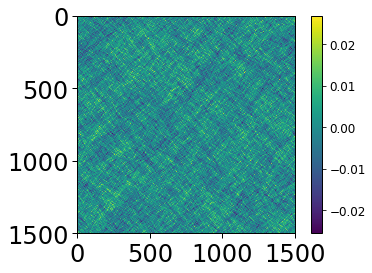

In [14]:
io.plot_img(imaps[0])
io.plot_img(imaps[1])
io.plot_img(imaps[2])

In [165]:
# power spectra
modlmap = enmap.modlmap(shape,wcs)
bin_edges = np.arange(50,3000,80)
binner = stats.bin2D(modlmap,bin_edges)
fc = maps.FourierCalc(shape,wcs,iau=False)
N = 20

s = stats.Stats()
for i in range(N):
    imaps = mg.get_map(scalar=False,iau=False)
    p2d, kkappa, _ = fc.power2d(imaps)
    #cents, eclkk = binner.bin(p2d[0,0])
    cents, eclkg = binner.bin(p2d[0,1])
    #cents, eclgg = binner.bin(p2d[1,1])
    s.add_to_stats("clkg",eclkg)
s.get_stats()

AttributeError: 'FourierCalc' object has no attribute 'rot'

In [ ]:
pl = io.Plotter(yscale='log')
#pl.add(cents,eclkk,marker="o",ls="none",color="C0")
pl.add_err(cents,s.stats["clkg"]['mean'],yerr=s.stats["clkg"]['errmean'],marker="o",ls="none",color="C1")
#pl.add(cents,eclgg,marker="o",ls="none",color="C2")
#pl.add(ellrange,clgg,color="C2")
#pl.add(ellrange,clkk,color="C0")
pl.add(ellrange,clkg,color="C1")
pl.done()

from scipy.interpolate import interp1d
cltheory2d = interp1d(ellrange,clkg,bounds_error=False,fill_value=0.)(modlmap)
cents, cltheory = binner.bin(cltheory2d)


pl = io.Plotter()
pl.add_err(cents,(s.stats["clkg"]['mean']-cltheory)/cltheory,yerr=s.stats["clkg"]['errmean']/cltheory,marker="o",ls="none",color="C1")
pl.hline()
pl.done()

In [166]:
io.plot_img(stats.cov2corr(s.stats["clkg"]['cov']),flip=False)


AttributeError: 'Stats' object has no attribute 'stats'

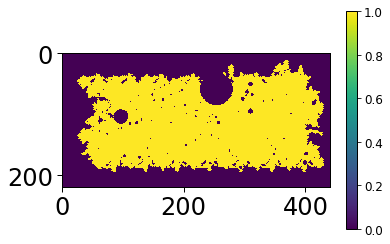

(220, 440)


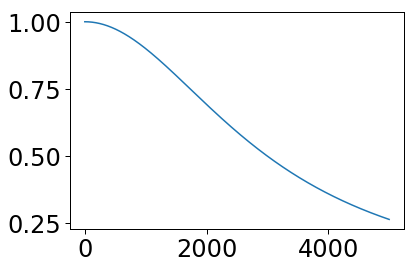

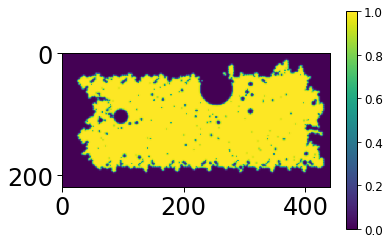

In [167]:
maskf = "/home/msyriac/data/xmm_mask.fits"
mask = enmap.read_map(maskf)
io.plot_img(mask)
print(mask.shape)
shape,wcs  = mask.shape,mask.wcs
modlmap = enmap.modlmap(shape,wcs)
#kfilter = maps.gauss_beam(modlmap,fwhm=6.0)
ell0 = 3000
bwn = 1
kfilter = maps.butterworth(modlmap,ell0,bwn)
fells = np.arange(0,5000,1)
kfilter1d = maps.butterworth(fells,ell0,bwn)
mask = maps.filter_map(mask,kfilter)
mask /= mask.max()
mask[mask<0] = 0

pl = io.Plotter()
pl.add(fells,kfilter1d)
#pl.hline()
pl.done()

io.plot_img(mask)#,high_res=True)

(3, 220, 440)
cea:{cdelt:[0.025,0.025],crval:[34,0],crpix:[220.5,281.3],pv[2,1]=0.995}
60.1680803769


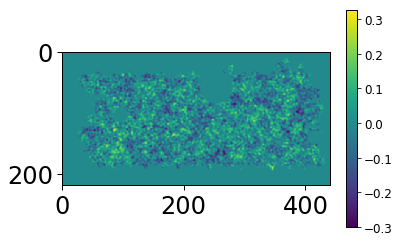

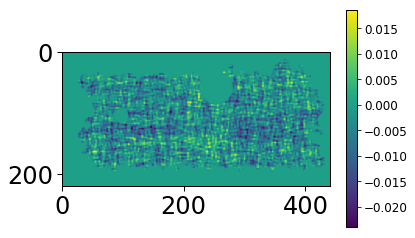

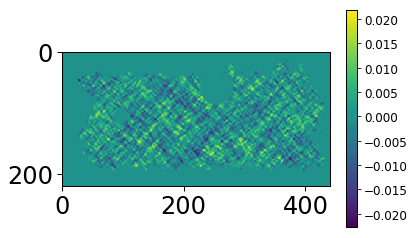

In [168]:
shape = (3,)+shape
print(shape)
print(wcs)
mg = maps.MapGen(shape,wcs,ps)
imaps = mg.get_map(scalar=False,iau=False)*mask
print(enmap.area(shape,wcs)*(180./np.pi)**2.)
io.plot_img(imaps[0])
io.plot_img(imaps[1])
io.plot_img(imaps[2])

In [214]:
# power spectra

bin_edges = np.arange(100,3000,300)
binner = stats.bin2D(modlmap,bin_edges)
fc = maps.FourierCalc(shape,wcs,iau=False)
N = 40

import orphics.analysis.pure as pure
res = maps.resolution(shape,wcs) #*60.*180./np.pi
#wins = pure.initializeDerivativesWindowfuntions(mask,res)                                                                                                 
#lxMap,lyMap,modlmap,anglmap,lx,ly = maps.get_ft_attributes(shape,wcs)
anglmap = maps.angmap(shape,wcs,iau=False)

w2 = np.mean(mask**2.)
print(w2)
s = stats.Stats()
for i in range(N):
    imaps = mg.get_map(scalar=False,iau=False)*mask
    
    #ft,fe,fb = pure.TQUtoPureTEB(imaps[0],imaps[1],imaps[2],modlmap,anglmap,wins,method='pure')                                                                        
    #cpure = fc.f2power(ft,fe)
    #cents, pclkg = binner.bin(cpure)
    #s.add_to_stats("pclkg",pclkg)
    
    p2d, kkappa, _ = fc.power2d(imaps)
    p2d /= w2
    cents, eclkg = binner.bin(p2d[0,1])
    s.add_to_stats("clkg",eclkg)
s.get_stats()

0.529762075364


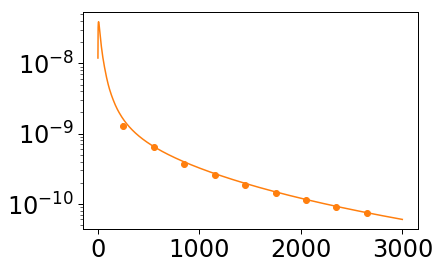

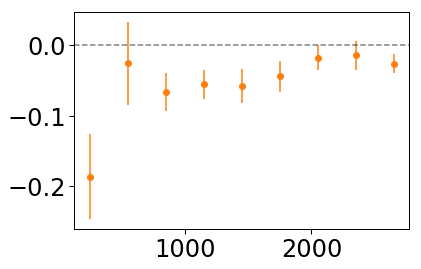

In [215]:
#print(s.stats["pclkg"]['mean'])
pl = io.Plotter(yscale='log')
pl.add_err(cents,s.stats["clkg"]['mean'],yerr=s.stats["clkg"]['errmean'],marker="o",ls="none",color="C1")
#pl.add_err(cents,s.stats["pclkg"]['mean'],yerr=s.stats["pclkg"]['errmean'],marker="o",ls="none",color="C2")
pl.add(ellrange,clkg,color="C1")
#pl.add(ellrange,clgg,color="C2")
pl.done()

from scipy.interpolate import interp1d
cltheory2d = interp1d(ellrange,clkg,bounds_error=False,fill_value=0.)(modlmap)
cents, cltheory = binner.bin(cltheory2d)


pl = io.Plotter()
pl.add_err(cents,(s.stats["clkg"]['mean']-cltheory)/cltheory,yerr=s.stats["clkg"]['errmean']/cltheory,marker="o",ls="none",color="C1")
pl.hline()
pl.done()

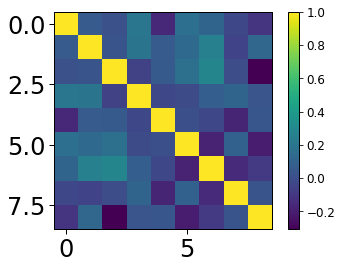

In [216]:
io.plot_img(stats.cov2corr(s.stats["clkg"]['cov']),flip=False)
#io.plot_img(stats.cov2corr(s.stats["pclkg"]['cov']),flip=False)

In [256]:
from numpy.fft import fftshift, ifftshift

def trimShiftKMap(kMap,elTrim,Lx,Ly,lx,ly):
    """
    @brief Trims a 2-D powerMap at a certain Lx, Ly, and returns the trimmed kMap object
    trimmed at elTrim and shifted by Lx and Ly
    """
    # assert(elTrim>0.)
    
    # assert((lx[0] != 0.) and (ly[0] != 0.))
    
    #kM = kMap.copy()
    idx = np.where(np.logical_and(lx < elTrim+Lx,lx > -elTrim+Lx))
    idy = np.where(np.logical_and(ly < elTrim+Ly,ly > -elTrim+Ly))
    trimA = kMap[idy[0],:]
    trimB = trimA[:,idx[0]]
    #print(kMap.shape,elTrim,Lx,Ly,lx.shape,ly.shape,trimA.shape,trimB.shape,idy[0].shape,idx[0].shape)
    kTrimmed = trimB
    del trimA,trimB
    return kTrimmed

def mcm(shape,wcs,power,bin_edges,kmask,transfer = None,binningWeightMap = None):
    """
    window: data window
    
    """
    lxMap,lyMap,modLMap,anglmap,llx,lly = maps.get_ft_attributes(shape,wcs)
    lmax = 10000 #int(modLMap.max())
    Ny,Nx = shape[-2:]
    powerOfL = 0
    trimAtL = lmax+1000

    binLo = bin_edges[:-1]
    binHi = bin_edges[1:]
    
    powerMask = power
    powerMaskShifted = fftshift(powerMask)
    phlx = fftshift(llx)
    phly = fftshift(lly)
    if transfer != None:
        ell, f_ell = transfer
        t.powerMap *= pixW2d
        transferTrim = t.trimAtL(trimAtL)
        
        
    if binningWeightMap ==None:
        binningWeightMap = powerMask.copy()*0.+1.0
    else:
        assert(binningWeightMap.shape == powerMask.shape)
        
        
    powerMaskTrim = powerMask*kmask
    
    pMMaps = []
    
    mArray = np.zeros(shape=(len(binLo),len(binLo)))
    Bbl = np.zeros(shape=(len(binLo),np.int(trimAtL)))
    
    modIntLMap = np.array(modlmap + 0.5,dtype='int64')
    cumTerms = 0
    for ibin in range(len(binLo)):
        
        location = np.where((modIntLMap >= binLo[ibin]) & (modIntLMap <= binHi[ibin]))
        binMap = powerMask.copy()*0.
        binMap[location] = binningWeightMap[location]
        sumBin = binMap.sum()
        binMap[location] *= modLMap[location]**powerOfL
        assert(sumBin>0.)
        
        binMap0 = (trimShiftKMap(powerMaskShifted,trimAtL,0,0,\
                                               phlx,phly))*0.

        
        deltaT = 0.
        cumTerms += len(location[0])
        #print(len(location[0]))
        #sys.exit()
        for i in range(len(location[0])):
            ly = lly[location[0][i]]
            lx = llx[location[1][i]]
            #  print ly, lx, trimAtL
            #print(binMap0.shape)
            tkmap = trimShiftKMap(powerMaskShifted,trimAtL,lx,ly,phlx,phly)
            #print(tkmap.shape,powerMaskShifted.shape,trimAtL,lx.shape,ly.shape,phlx.shape,phly.shape)
            binMap0 += binMap[location[0][i],location[1][i]]*(tkmap)
        binMap0 = ifftshift(binMap0)
        if transfer != None:
            pMMaps.append(binMap0[:]*transferTrim.powerMap[:]/sumBin)
        else:
            pMMaps.append(binMap0/sumBin)
 
    larray = np.arange(np.int(trimAtL))
    deltaLx = np.abs(modLMap[0,1] - modLMap[0,0])
    deltaLy = np.abs(modLMap[1,0] - modLMap[0,0])
    delta = np.min([deltaLx,deltaLy])/2.0
    gaussFactor = 1./np.sqrt(2.*np.pi*delta**2.)

    modLMapInt = np.array(modLMap+0.5, dtype='int64')

    
    for j in range(len(binHi)):
        location = np.where((modLMapInt >= binLo[j]) &\
                               (modLMapInt <= binHi[j]))
        binMapTrim = powerMaskTrim.copy()*0.
        binMapTrim[location] = 1.
        binMapTrim[location] *= np.nan_to_num(1./(modLMap[location])**powerOfL)
        for i in range(len(pMMaps)):
            newMap = pMMaps[i].copy()
            result = (newMap*binMapTrim).sum()
            mArray[i,j] = result

        
    modMap = np.ravel(modLMap)    
    deltaLx = np.abs(llx[1]-llx[0])
    deltaLy = np.abs(lly[1]-lly[0])
    

    for k in range(len(larray)):
        
        gauss = np.exp(-(larray-larray[k])**2./(2.*delta**2.))
        sum = gauss.sum()
        gauss = np.exp(-(modMap-larray[k])**2./(2.*delta**2.))
        gauss /= sum 
        binMapTrim = np.reshape(gauss,[Ny,Nx])
        
        
        
        binMapTrim *= modLMap**powerOfL
        for i in range(len(pMMaps)):
            #newMap = pMMaps[i].copy()
            result = (pMMaps[i]*binMapTrim).sum()
            Bbl[i,k] = result

    import scipy
    Bbl = np.dot(scipy.linalg.inv(mArray), Bbl)
    
    return mArray


In [257]:
print(imaps.shape)
print(mask.shape)
power_mask,_,_ = fc.power2d(mask)
kmask = maps.mask_kspace(shape,wcs,lmax=modlmap.max())
mmat = mcm(shape,wcs,power_mask,bin_edges,kmask)

(3, 220, 440)
(220, 440)


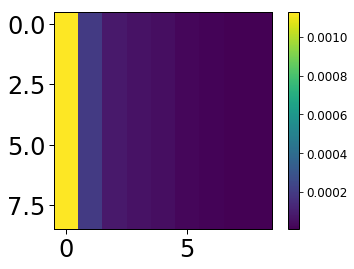

In [258]:
io.plot_img(mmat)